<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - Photovoltaic Farms Mapping

## User Defined Process (UDP) creation for model inference using openEO

## UDP for photovoltaic farms mapping creation

Firstly we import the required libraries and  establish a connection with the openEO back-end.

In [1]:
import json
import openeo
from urllib.parse import urljoin
from openeo.api.process import Parameter
from openeo.rest.udp import build_process_dict

# Connect and authenticate
conn = openeo.connect("https://openeo.cloud/").authenticate_oidc()
# Alternatively you can also use the Copernicus Data Space Ecosystem (CDSE)
# conn = openeo.connect("https://openeo.dataspace.copernicus.eu/").authenticate_oidc()

Authenticated using refresh token.


Define the changeable parameters: spatial extent, temporal extent and the model url.

In [2]:
spatial_extent_param = Parameter(
      name= "spatial_extent",
      description= "A bounding box, which may include a vertical axis (see `base` and `height`).",
      schema = {
        "type": "object",
        "subtype": "bounding-box",
        "required": [
          "west",
          "south",
          "east",
          "north"
        ],
        "properties": {
          "west": {
            "description": "West (lower left corner, coordinate axis 1).",
            "type": "number"
          },
          "south": {
            "description": "South (lower left corner, coordinate axis 2).",
            "type": "number"
          },
          "east": {
            "description": "East (upper right corner, coordinate axis 1).",
            "type": "number"
          },
          "north": {
            "description": "North (upper right corner, coordinate axis 2).",
            "type": "number"
          },
          "base": {
            "description": "Base (optional, lower left corner, coordinate axis 3).",
            "type": [
              "number",
              "null"
            ],
            "default": None
          },
          "height": {
            "description": "Height (optional, upper right corner, coordinate axis 3).",
            "type": [
              "number",
              "null"
            ],
            "default": None
          },
          "crs": {
            "description": "Coordinate reference system of the extent, specified as as [EPSG code](http://www.epsg-registry.org/) or [WKT2 CRS string](http://docs.opengeospatial.org/is/18-010r7/18-010r7.html). Defaults to `4326` (EPSG code 4326) unless the client explicitly requests a different coordinate reference system.",
            "anyOf": [
              {
                "title": "EPSG Code",
                "type": "integer",
                "subtype": "epsg-code",
                "minimum": 1000,
                "examples": [
                  3857
                ]
              },
              {
                "title": "WKT2",
                "type": "string",
                "subtype": "wkt2-definition"
              }
            ],
            "default": 4326
          }
        }
      }
)
temporal_extent = Parameter(
    name="temporal_extent",
    description="The date range to calculate the temporal median for.",
    schema={"type": "array", "subtype": "temporal-interval"},
    default =["2023-05-01", "2023-09-30"])

inference_url_param = Parameter.string(
    name="inference_url",
    default="https://artifactory.vgt.vito.be/artifactory/auxdata-public/photovoltaic/rf_1_median_depth_15.onnx",
    description="url to the inference network, must be on VITO artifactory",
)

Create the Photovoltaic Farms Mapping process graph that we want to make shareable:

In [3]:
from utils import preprocess_sentinel2_data, postprocess_inference_data

s2_cube = preprocess_sentinel2_data(conn,  spatial_extent_param, temporal_extent)

# Supply the model as a URL. The model is stored in artifactory
udf = openeo.UDF.from_file(
    "udf_rf_onnx.py", 
    context={
        "model_url": inference_url_param
    }
)

# Reduce the bands dimension using the inference udf
prediction = s2_cube.reduce_bands(reducer=udf)

# Post process the result with opening operation (erosion + dilation)
prediction_filtered = postprocess_inference_data(prediction, 3) 

/home/mclaus@eurac.edu/openeo-python-client/openeo/rest/connection.py:1195: UserWarning: SENTINEL2_L2A property filtering with properties that are undefined in the collection metadata (summaries): eo:cloud_cover.
  return DataCube.load_collection(


Store the process graph on the back-end and locally:

In [4]:
#provide a UDP ID:
UDP_ID = "photovoltaic_farms_mapping"

#save the graph on the back-end
conn.save_user_defined_process(
    user_defined_process_id=UDP_ID,
    process_graph=prediction_filtered,
    parameters=[spatial_extent_param, temporal_extent, inference_url_param]
)

#save it locally as a JSON
spec = build_process_dict(
    process_id=UDP_ID,
    process_graph=prediction_filtered,
    parameters=[spatial_extent_param, temporal_extent, inference_url_param]

)
with open("photovoltaic_farms_mapping.json", "w") as f:
    json.dump(spec, f, indent=2)

Preflight process graph validation raised: [UpstreamValidationInfo] Backend 'vito' reported validation errors [ProcessParameterRequired] Process 'n/a' parameter 'spatial_extent' is required.


In [5]:
# In case of need, you can also delete a UDP in this way:
# conn.user_defined_process(UDP_ID).delete()

## UDP excecution

We now reuse the previously defined UDP to detect photovoltaic farms over a sample area in Austria:

In [6]:
inference_result = conn.datacube_from_process(
    process_id=UDP_ID,
    spatial_extent={
            "east": 16.414,
            "north": 48.008,
            "south": 47.962,
            "west": 16.342
    },
    temporal_extent = ["2023-05-01", "2023-09-30"],
    inference_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/photovoltaic/rf_1_median_depth_15.onnx")

inference_result.execute_batch(
    "./result.tiff",
    title="photovoltaic_farms_mapping"
)

Preflight process graph validation raised: [UpstreamValidationInfo] Backend 'vito' reported validation errors [ProcessUnsupported] Process with identifier 'photovoltaic_farms_mapping' is not available in namespace 'backend'.


0:00:00 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': send 'start'
0:00:17 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': queued (progress N/A)
0:00:23 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': queued (progress N/A)
0:00:30 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': queued (progress N/A)
0:00:38 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': queued (progress N/A)
0:00:49 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': queued (progress N/A)
0:01:02 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': queued (progress N/A)
0:01:17 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': queued (progress N/A)
0:01:37 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': queued (progress N/A)
0:02:02 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': running (progress N/A)
0:02:32 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': running (progress N/A)
0:03:10 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': running (progress N/A)
0:03:57 Job 'vito-j-2404118171424ae9aee5e89b4b4666fe': running (progress N/A)
0:04

<BatchJob job_id='vito-j-2404118171424ae9aee5e89b4b4666fe'>

## Result Visualization

We firstly get the RGB composite for reference and visualize the mapped photovoltaic farms

In [8]:
conn.load_collection(
    "SENTINEL2_L2A",
    spatial_extent={
            "east": 16.414,
            "north": 48.008,
            "south": 47.962,
            "west": 16.342
    },
    temporal_extent = ["2023-07-01", "2023-07-30"],
    bands = ["B04","B03","B02"]).reduce_dimension(dimension="t",reducer="median").download("rgb_composite.tiff")

Open the RGB and photovoltaic mapping files:

In [64]:
import rioxarray
rgb = rioxarray.open_rasterio("rgb_composite.tiff")
pv_farms = rioxarray.open_rasterio("result.tiff")

Show the RGB Sentinel-2 composite:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


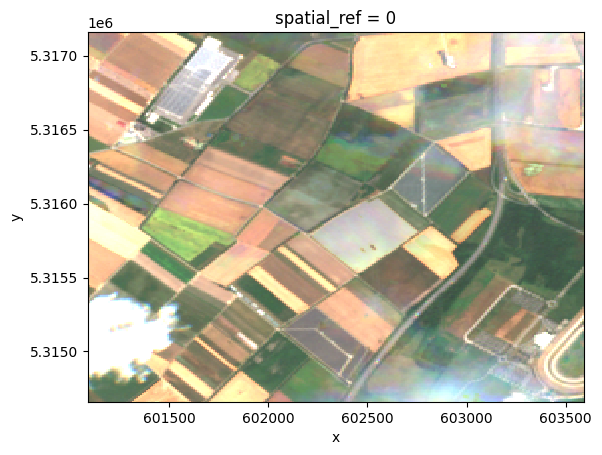

In [65]:
(rgb/2000)[:,100:350,100:350].plot.imshow()

Show it again with the mapped photovoltaic farms as red overlay:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


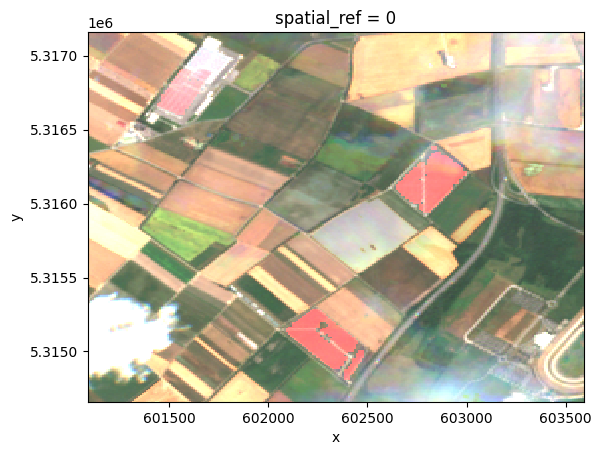

In [66]:
rgb[0] = rgb[0] + pv_farms[0]*2000
(rgb/2000)[:,100:350,100:350].plot.imshow()